### О проекте

#### Название проекта

Система автоматического анализа общественных настроений на основе новостных публикаций и социальных сообщений.

#### Какую задачу решает продукт

Продукт решает задачу автоматизации анализа медиапространства, он позволяет быстро и объективно оценивать общественные настроения по большим массивам текстов (новостей, постов, комментариев), выявлять тренды и изменения восприятия определённых тем или событий.

Тем самым он помогает организациям и частным лицам сократить время аналитики, уменьшить ручные затраты и повысить точность мониторинга общественного мнения.

### baseline

В качестве основной метрики качества модели используется **Macro F1-score**.

**Обоснование выбора метрики:**
- распределение классов тональности является несбалансированным (класс *нейтральный* встречается значительно чаще других);
- важно оценивать качество классификации для каждого класса, включая редкие (*позитив*, *негатив*);
- метрика **Macro F1** равноправно учитывает вклад всех классов и не смещена в сторону доминирующего.

На предыдущем этапе был построен baseline. Лучшая модель по совокупным метрикам — **TF-IDF + Logistic Regression**.

#### Результаты экспериментов

- dataset: [sentiment-analysis-in-russian](https://www.kaggle.com/competitions/sentiment-analysis-in-russian) (Kaggle)

| Модель                         | Test F1-macro | Test Accuracy | Совокупная метрика |
|--------------------------------|---------------|----------------|----------------------|
| **TF-IDF + Logistic Regression** | **0.7493**     | **0.7560**      | **0.7527**            |
| fastText + Logistic Regression | 0.5549        | 0.5612          | 0.5581                |
| RuBERT (tiny2)                | 0.6756        | 0.6899          | 0.6828                |


### Импорты

In [1]:
import os
import re
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple

import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import torch
from torch.utils.data import DataLoader
from safetensors.torch import load_file
import torch.nn as nn
from torch.utils.data import Dataset as dataset_torch

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    AutoModel,
    AutoConfig,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split

import emoji

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Улучшение данных и предобработки

#### 1.1 Использовать более объёмный датасет

- Датасет – [MonoHime/ru_sentiment_dataset](https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset). Он так же включает в себя [sentiment-analysis-in-russian](https://www.kaggle.com/competitions/sentiment-analysis-in-russian)

**Идея:** сначала обучаем модель на многодоменном наборе данных (новости, отзывы, токсичные комментарии и т. д.), чтобы она уловила общую картину. Затем отдельно дообучаем на новостях из набора Kaggle (sentiment-analysis-in-russian). Это должно положительно сказаться на качестве обучения ruBERT-tiny2, поскольку объём данных существенно увеличится.

##### Загрузка Kaggle news

In [2]:
path = "/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/data/sentiment-analysis-in-russian/train.json"

kaggle_df = pd.read_json(path)

str2id = {"neutral": 0, "positive": 1, "negative": 2}
kaggle_df["label"] = kaggle_df["sentiment"].map(str2id)

kaggle_df = kaggle_df.drop(columns=['id', 'sentiment'])

In [3]:
kaggle_df.shape

(8263, 2)

In [4]:
kaggle_df.head()

,text,label
0,Досудебное расследование по факту покупки ЕНПФ...,2
1,Медики рассказали о состоянии пострадавшего му...,2
2,"Прошел почти год, как железнодорожным оператор...",2
3,По итогам 12 месяцев 2016 года на территории р...,2
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,2


##### Загрузка MonoHime/ru_sentiment_dataset 

In [5]:
def load_mono_dataset() -> DatasetDict:
    """
    Загружает MonoHime/ru_sentiment_dataset с HuggingFace.
    Возвращает DatasetDict с train/validation.
    Колонки: 'text' (str), 'sentiment' (int: 0: NEUTRAL, 1: POSITIVE, 2: NEGATIVE).
    """
    ds = load_dataset("MonoHime/ru_sentiment_dataset")
    # Переименуем 'sentiment' в 'label' для удобства
    ds = ds.rename_column("sentiment", "label")
    return ds

In [6]:
mono_ds = load_mono_dataset()

Преобразуем в df для удобства анализа

In [7]:
mono_train_df = mono_ds['train'].to_pandas()
mono_val_df   = mono_ds['validation'].to_pandas()

mono_df = pd.concat([mono_train_df, mono_val_df]).reset_index(drop=True).drop(columns=['Unnamed: 0'])

In [8]:
mono_df.shape

(210989, 2)

In [9]:
mono_df.head()

,text,label
0,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,Непорядочное отношение к своим работникам Рабо...,2
3,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,У меня машина в руках 5 лет и это п...,1


Удалим строки в MonoHime, чьи тексты встречаются в Kaggle

In [10]:
def normalize(t: str) -> str:
    t = t.lower()
    t = t.strip()
    t = re.sub(r'\s+', ' ', t)          # схлопываем пробелы
    t = re.sub(r'https?://\S+', '', t)  # убираем ссылки
    t = re.sub(r'[^\S\r\n]+', ' ', t)   # всякие непечатаемые в пробел
    return t

mono_df['norm']   = mono_df['text'].apply(normalize)
kaggle_df['norm'] = kaggle_df['text'].apply(normalize)

In [11]:
mask = mono_df['norm'].isin(kaggle_df['norm'])

mono_df[mask].shape[0], kaggle_df.shape[0]

(8263, 8263)

In [12]:
mono_df_adj = mono_df[~mask].copy()

mono_df.shape[0] - mono_df_adj.shape[0]

8263

#### 1.2 Улучшенная предобработка текста

##### Очистка данных

In [13]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
whitespace_pattern = re.compile(r"\s+")

def clean_text(text: str) -> str:
    # Удаляем эмодзи
    text = emoji.replace_emoji(text, replace=" ")
    
    # URL маркер
    text = url_pattern.sub(" URL ", text)
    
    # @mentions маркер
    text = mention_pattern.sub(" @USER ", text)
    
    # убираем '#' оставляем слово
    text = hashtag_pattern.sub(r"\1", text)
    
    # Сжимаем пробелы
    text = whitespace_pattern.sub(" ", text).strip()
    
    return text

def drop_ambiguity(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    
    # Убираем шум
    df_copy['clean'] = df_copy['text'].apply(clean_text)
    
    # Проверяем консистентность лейблов у дублей
    mask = df_copy.duplicated(subset = 'clean', keep=False)
    df_temp = df_copy[mask].groupby('clean')['label'].nunique()
    
    # Удаляем объекты где лейблы неоднозначны
    lst_drop = df_temp[df_temp > 1].index.tolist()
    df_copy = df_copy[~df_copy['clean'].isin(lst_drop)]

    df_copy = df_copy[['clean', 'label']].copy().rename(columns={'clean': 'text'})

    # Удаляем дубликаты по остальным объектам
    df_copy.drop_duplicates(subset='text', inplace=True)

    # Убираем выбросы по длине текста
    df_copy['len'] = df_copy['text'].str.split().str.len()

    lower = df_copy['len'].quantile(0.01)
    upper = df_copy['len'].quantile(0.99)

    df_result = df_copy.loc[(df_copy['len'] > lower) & (df_copy['len'] < upper), ['text', 'label']].copy()

    return df_result

In [14]:
%%time

mono_df_processed   = drop_ambiguity(mono_df_adj)
kaggle_df_processed = drop_ambiguity(kaggle_df)

CPU times: user 59.8 s, sys: 435 ms, total: 1min
Wall time: 1min


In [15]:
before      = mono_df_adj['text'].duplicated().sum()
before_size = mono_df_adj.shape[0]

after      = mono_df_processed['text'].duplicated().sum()
after_size = mono_df_processed.shape[0]

print(f"Mono duplicates: {before} -> {after}.\n\nMono size: {before_size} -> {after_size}.")

Mono duplicates: 10228 -> 0.

Mono size: 202726 -> 184804.


In [16]:
before      = kaggle_df['text'].duplicated().sum()
before_size = kaggle_df.shape[0]

after      = kaggle_df_processed['text'].duplicated().sum()
after_size = kaggle_df_processed.shape[0]

print(f"Kaggle duplicates: {before} -> {after}.\n\nKaggle size: {before_size} -> {after_size}.")

Kaggle duplicates: 314 -> 0.

Kaggle size: 8263 -> 7459.


In [19]:
# сохраняем для DVC

mono_df_processed.to_parquet('/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/data/monohime-ru-sentiment-dataset/monohime.parquet', index=False)

##### Конвертация в HF Dataset

###### Kaggle

In [20]:
def df_to_hf_dataset(df: pd.DataFrame) -> Dataset:
    ds = Dataset.from_pandas(df.reset_index(drop=True))
    ds = ds.remove_columns(
        [c for c in ds.column_names if c.startswith("__index")]
    )
    return ds

kaggle_train_df, kaggle_val_df = train_test_split(
    kaggle_df_processed,
    test_size=0.15,
    stratify=kaggle_df_processed["label"],
    random_state=42,
)

kaggle_train_ds = df_to_hf_dataset(kaggle_train_df)
kaggle_val_ds   = df_to_hf_dataset(kaggle_val_df)

kaggle_ds_final = DatasetDict(train=kaggle_train_ds, validation=kaggle_val_ds)

In [35]:
kaggle_ds_final

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6340
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1119
    })
})

###### Mono

In [22]:
mono_train_df, mono_val_df = train_test_split(
    mono_df_processed,
    test_size=0.15,
    stratify=mono_df_processed["label"],
    random_state=42,
)

mono_train_ds = df_to_hf_dataset(mono_train_df)
mono_val_ds   = df_to_hf_dataset(mono_val_df)

mono_ds_final = DatasetDict(train=mono_train_ds, validation=mono_val_ds)

In [36]:
mono_ds_final

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 157083
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 27721
    })
})

##### Токенизация + обработка длинных текстов

In [37]:
def smart_truncate(text: str, max_words_head: int = 256, max_words_tail: int = 64) -> str:
    """
    Простая head+tail обрезка по словам перед токенизацией.
    Сначала берём первые max_words_head слов, затем последние max_words_tail.
    """
    words = text.split()
    if len(words) <= max_words_head + max_words_tail:
        return text
    head = words[:max_words_head]
    tail = words[-max_words_tail:]
    return " ".join(head + ["[...]"] + tail)

def preprocess_function(examples):
    truncated = [smart_truncate(t) for t in examples["text"]]
    tokenized = tokenizer(
        truncated,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )
    tokenized["labels"] = examples["label"]
    return tokenized

MAX_LENGTH = 384  # компромисс для новостей/постов
MODEL_CHECKPOINT = "cointegrated/rubert-tiny2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

mono_tokenized = mono_ds_final.map(
    preprocess_function,
    batched=True,
    desc="Tokenizing MonoHime dataset",
)

kaggle_tokenized = kaggle_ds_final.map(
    preprocess_function,
    batched=True,
    desc="Tokenizing Kaggle dataset",
)

Tokenizing MonoHime dataset:   0%|          | 0/157083 [00:00<?, ? examples/s]

Tokenizing MonoHime dataset:   0%|          | 0/27721 [00:00<?, ? examples/s]

Tokenizing Kaggle dataset:   0%|          | 0/6340 [00:00<?, ? examples/s]

Tokenizing Kaggle dataset:   0%|          | 0/1119 [00:00<?, ? examples/s]

### 2. Улучшенние модели

**Идея улучшения:**
- В baseline RuBERT-tiny2 использовал стандартный head: CLS -> Linear, который является по сути линейным классификатором.
- Я улучшу архитектуру, добавив “умный head”: сделав агрегацию CLS + mean pooling, добавив скрытый слой с GELU и dropout.
- Это позволит модели использовать информацию не только из CLS, но и из всего текста, что должно повысить выразительность классификатора и улучшить устойчивость без увеличения времени инференса.

In [38]:
class RuBertTiny2CustomHead(nn.Module):
    def __init__(self, model_name: str, num_labels: int, dropout: float = 0.2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        hidden = self.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, hidden // 2)
        self.act = nn.GELU()
        self.out = nn.Linear(hidden // 2, num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state          

        cls_emb = last_hidden[:, 0]                      

        if attention_mask is None:
            mean_emb = last_hidden.mean(dim=1)
        else:
            mask = attention_mask.unsqueeze(-1)          
            summed = (last_hidden * mask).sum(1)         
            denom = mask.sum(1).clamp(min=1e-9)          
            mean_emb = summed / denom                    

        x = torch.cat([cls_emb, mean_emb], dim=-1)       

        x = self.dropout(x)
        x = self.fc(x)
        x = self.act(x)
        x = self.dropout(x)
        logits = self.out(x)                             

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

def init_model():
    return RuBertTiny2CustomHead(MODEL_CHECKPOINT, num_labels=3)

### 3. Обучение

#### Stage 1: дообучение на дополнительном датасете

##### Инициализация модели

In [40]:
model_stage1 = init_model()

##### Параметры обучения

In [46]:
BATCH_SIZE = 16
MODEL_NAME = "rubert_tiny2_custom_stage1"
NUM_LABELS = 3                            
NUM_EPOCH = 2
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
LR_SCHEDULER_TYPE = "linear"
METRIC_FOR_BEST_MODEL = "f1_macro"
SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

training_args_stage1 = TrainingArguments(
    output_dir="/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCH,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    dataloader_pin_memory=False
)

Device: cpu


##### Метрики

In [47]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1_macro}

id2label = {0: "neutral", 1: "positive", 2: "negative"}
label2id = {v: k for k, v in id2label.items()}

##### Запуск

In [48]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

trainer_stage1 = Trainer(
    model=model_stage1,
    args=training_args_stage1,
    train_dataset=mono_tokenized["train"],
    eval_dataset=mono_tokenized["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer_stage1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.448300,0.438848,0.806537,0.782853
2,0.365100,0.418548,0.819487,0.804210


TrainOutput(global_step=19636, training_loss=0.4629693581582476, metrics={'train_runtime': 4410.1371, 'train_samples_per_second': 71.237, 'train_steps_per_second': 4.452, 'total_flos': 0.0, 'train_loss': 0.4629693581582476, 'epoch': 2.0})

##### Сохраняем чекпоинт Stage 1

In [49]:
trainer_stage1.save_model("/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best")
tokenizer.save_pretrained("/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best")

('/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best/tokenizer_config.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best/special_tokens_map.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best/vocab.txt',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best/added_tokens.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best/tokenizer.json')

#### Stage 2: дообучение только на Kaggle news

##### Инициализация модели

In [50]:
model_stage2 = init_model()

stage1_dir = "/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage1/best"
stage1_ckpt = f"{stage1_dir}/model.safetensors"

state_dict = load_file(stage1_ckpt)
model_stage2.load_state_dict(state_dict)

<All keys matched successfully>

##### Параметры обучения

In [51]:
MODEL_NAME = "rubert_tiny2_custom_stage2"
NUM_LABELS = 3               
NUM_EPOCH = 10
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
LR_SCHEDULER_TYPE = "linear"
METRIC_FOR_BEST_MODEL = "f1_macro"
SEED = 42

training_args_stage2 = TrainingArguments(
    output_dir="/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCH,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    dataloader_pin_memory=False,
)

##### Запуск Stage 2

In [52]:
# Настройка MLflow

mlflow.set_tracking_uri("http://127.0.0.1:5050")
mlflow.set_experiment("improving-model-rubert")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1765098867143, experiment_id='1', last_update_time=1765098867143, lifecycle_stage='active', name='improving-model-rubert', tags={}>

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.855200,0.829710,0.604111,0.570652
2,0.715600,0.761618,0.639857,0.631035
3,0.650700,0.752709,0.652368,0.647571
4,0.616400,0.740191,0.665773,0.654360
5,0.586300,0.748593,0.670241,0.668462
6,0.553400,0.747123,0.681859,0.678795
7,0.471200,0.773237,0.684540,0.685199
8,0.450600,0.775448,0.689902,0.688659
9,0.441700,0.786936,0.689008,0.688155
10,0.434800,0.798117,0.689008,0.688130


2025/12/07 14:19:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rubert_tiny2_custom_stage2 at: http://127.0.0.1:5050/#/experiments/1/runs/1e809c1fa4b34b298e044a39fc52a2fa
🧪 View experiment at: http://127.0.0.1:5050/#/experiments/1


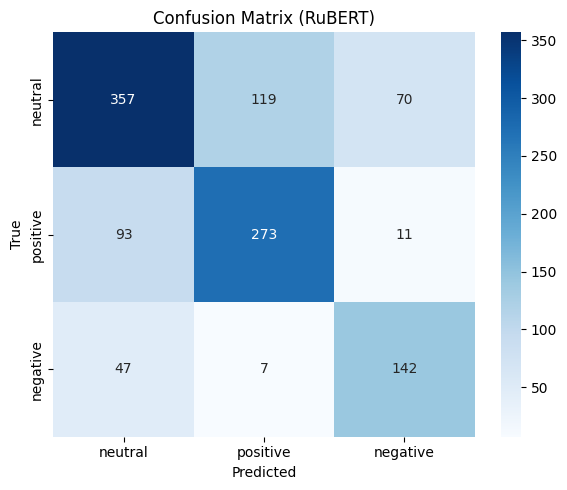

In [53]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

with mlflow.start_run(run_name=MODEL_NAME):

    # логирование параметров
    mlflow.log_params({
        "model_name": MODEL_NAME,
        "num_labels": NUM_LABELS,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCH,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "seed": SEED,
        "train_size": len(kaggle_tokenized['train']),
        "val_size": len(kaggle_tokenized['validation']),
        "dataset_name": "Sentiment Analysis in Russian"
    })

    # остановимся, если 2 эпохи подряд нет улучшения f1_macro
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=2,    
        early_stopping_threshold=0.0,
    )
    
    trainer_stage2 = Trainer(
        model=model_stage2,
        args=training_args_stage2,
        train_dataset=kaggle_tokenized["train"],
        eval_dataset=kaggle_tokenized["validation"],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping],
    )
    
    trainer_stage2.train()

    # логируем историю eval по эпохам 
    history = trainer_stage2.state.log_history
    for row in history:
        if "eval_loss" in row:
            epoch = row.get("epoch")
            for k, v in row.items():
                if isinstance(v, (int, float)):
                    mlflow.log_metric(
                        key=k,
                        value=v,
                        step=int(epoch) if epoch is not None else None
                    )

    # оценка на validation
    preds_output = trainer_stage2.predict(kaggle_tokenized["validation"])
    logits = preds_output.predictions
    labels = preds_output.label_ids
    preds = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    
    mlflow.log_metrics({
        "val_accuracy_final": acc,
        "val_f1_macro_final": f1m,
    })

    # артефакт отчета классификации
    report = classification_report(
        labels,
        preds,
        target_names=[id2label[i] for i in range(NUM_LABELS)],
        digits=4,
        zero_division=0,
    )
    with open("classification_report_rubert_stage2.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report_rubert_stage2.txt")

    # артефакт матрицы ошибок
    cm = confusion_matrix(labels, preds, labels=list(range(NUM_LABELS)))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[id2label[i] for i in range(NUM_LABELS)],
                yticklabels=[id2label[i] for i in range(NUM_LABELS)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (RuBERT)")
    plt.tight_layout()
    plt.savefig("confusion_matrix_rubert_stage2.png")
    mlflow.log_artifact("confusion_matrix_rubert_stage2.png")

    # сохранение модели
    mlflow.pytorch.log_model(
        pytorch_model=trainer_stage2.model,
        name="rubert_model_stage2"
    )

##### Сохраняем чекпоинт Stage 2

In [54]:
trainer_stage2.save_model("/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final")
tokenizer.save_pretrained("/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final")

('/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final/tokenizer_config.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final/special_tokens_map.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final/vocab.txt',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final/added_tokens.json',
 '/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final/tokenizer.json')

### 4. Постобработка предсказаний

Попробую применить пост-обработку предсказаний модели, чтобы повысить точность и устойчивость сентимента

**Подход будет включать:**

- Temperature scaling для стабилизации вероятностей;

- Классификация как neutral, если модель недостаточно уверена;

- Если разница между positive и negative мала, результат считается neutral;

- Обработка коротких текстов (1–2 слова почти не несут тональности);

- Лексические эвристики (ключевые позитивные/негативные слова, отрицание «не»);

- Перенормировка вероятностей после корректировок.

Ожидаю, что это улучшит macro-F1, уменьшит ложные экстремальные классы и сделает модель более надежной на реальных новостях

#### Конфиг и класс пост-процессора

In [58]:
@dataclass
class PostprocConfig:    
    temperature: float = 1.2          # T > 1 -> мягче вероятности
    neutral_conf_threshold: float = 0.0   # если max_prob < threshold -> neutral
    pos_neg_margin: float = 0.0       # если |p_pos - p_neg| < margin -> neutral
    short_text_words: int = 3         # если текст короче -> neutral
    negation_boost: float = 0.0       # сколько добавляем к negative при отрицании
    positive_boost: float = 0.0       # boost для позитивных ключевых слов
    negative_boost: float = 0.0       # boost для негативных ключевых слов


class SentimentPostProcessor:
    """
    Оборачивает сырые logits модели в более аккуратные предсказания
    с учётом правил для нейтральности, коротких текстов и ключевых слов.
    """
    def __init__(
        self,
        id2label: Dict[int, str],
        config: PostprocConfig | None = None,
    ):
        self.id2label = id2label
        self.label2id = {v: k for k, v in id2label.items()}
        self.config = config or PostprocConfig()

        # очень грубые словари, потом можешь расширить под свой домен
        self.positive_keywords = [
            "успех", "рост", "улучшение", "рекорд", "прибыль",
            "поддержка", "выиграл", "победа", "прорыв",
        ]
        self.negative_keywords = [
            "кризис", "падение", "убыток", "потери", "скандал",
            "катастрофа", "обвал", "санкции", "штраф",
        ]

    def _softmax(self, logits: np.ndarray) -> np.ndarray:
        logits = logits.astype("float64")  
        exp = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
        return exp / exp.sum(axis=-1, keepdims=True)

    def _apply_temperature(self, logits: np.ndarray) -> np.ndarray:
        T = self.config.temperature
        return logits / T

    def postprocess_single(
        self,
        text: str,
        logits: np.ndarray,
    ) -> Tuple[str, Dict[str, float]]:
        """
        Возвращает (final_label, probs_dict)
        """
        cfg = self.config
        text_l = text.lower()

        # Temperature scaling + softmax
        logits_t = self._apply_temperature(logits)
        probs = self._softmax(logits_t)
        p_neu, p_pos, p_neg = probs  # 0, 1, 2

        # Правило «слишком низкая уверенность -> neutral»
        if probs.max() < cfg.neutral_conf_threshold:
            return self.id2label[0], {
                self.id2label[i]: float(p) for i, p in enumerate(probs)
            }

        # pos/neg сильно не отличаются -> neutral
        if abs(p_pos - p_neg) < cfg.pos_neg_margin:
            return self.id2label[0], {
                self.id2label[i]: float(p) for i, p in enumerate(probs)
            }

        # Слишком короткий текст -> neutral
        if len(text.split()) < cfg.short_text_words:
            return self.id2label[0], {
                self.id2label[i]: float(p) for i, p in enumerate(probs)
            }

        # Простые правила по словам
        if " не " in f" {text_l} " or " ни " in f" {text_l} ":
            probs[self.label2id["negative"]] += cfg.negation_boost

        # ключевые слова
        if any(k in text_l for k in self.positive_keywords):
            probs[self.label2id["positive"]] += cfg.positive_boost
        if any(k in text_l for k in self.negative_keywords):
            probs[self.label2id["negative"]] += cfg.negative_boost

        # нормализуем снова до сумм=1 (после буста)
        probs = probs / probs.sum()

        final_id = int(np.argmax(probs))
        final_label = self.id2label[final_id]
        probs_dict = {self.id2label[i]: float(p) for i, p in enumerate(probs)}
        return final_label, probs_dict

    def __call__(
        self,
        texts: List[str],
        logits_batch: np.ndarray, 
    ) -> List[Dict]:
        """
        Обрабатывает батч. Возвращает список словарей:
        { "text": ..., "label": ..., "probs": {...} }
        """
        results = []
        for text, logits in zip(texts, logits_batch):
            label, probs_dict = self.postprocess_single(text, logits)
            results.append(
                {
                    "text": text,
                    "label": label,
                    "probs": probs_dict,
                }
            )
        return results

#### Оценка на validation

In [56]:
model_final = init_model()

stage2_dir = "/Users/kirill/PycharmProjects/nlp-media-sentiment-analysis/models/rubert_tiny2/rubert_tiny2_stage2/final"
stage2_ckpt = f"{stage2_dir}/model.safetensors"

state_dict = load_file(stage2_ckpt)
model_final.load_state_dict(state_dict)

device = torch.device("cpu")
model_final.to(device)
model_final.eval()

tokenizer = AutoTokenizer.from_pretrained(stage2_dir)

In [57]:
def evaluate_with_postproc(
    model,
    tokenized_ds,   
    texts,        
    batch_size: int = 32,
):
    model.eval()
    all_logits = []
    all_labels = []

    def collate_fn(examples):
        return {
            "input_ids": torch.tensor([e["input_ids"] for e in examples], dtype=torch.long),
            "attention_mask": torch.tensor([e["attention_mask"] for e in examples], dtype=torch.long),
            "labels": torch.tensor([e["labels"] for e in examples], dtype=torch.long),
        }

    loader = DataLoader(tokenized_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs["logits"].cpu().numpy()

            all_logits.append(logits)
            all_labels.append(labels)

    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Без пост-обработки
    raw_preds = np.argmax(all_logits, axis=-1)

    raw_acc = accuracy_score(all_labels, raw_preds)
    raw_f1 = f1_score(all_labels, raw_preds, average="macro")

    print("Без пост-обработки")
    print(f"Accuracy: {raw_acc:.4f}")
    print(f"F1-macro: {raw_f1:.4f}\n")

    # С пост-обработкой
    postproc = SentimentPostProcessor(id2label=id2label)
    post_results = postproc(texts, all_logits)
    post_preds = np.array([label2id[r["label"]] for r in post_results])

    post_acc = accuracy_score(all_labels, post_preds)
    post_f1 = f1_score(all_labels, post_preds, average="macro")

    print("С пост-обработкой")
    print(f"Accuracy: {post_acc:.4f}")
    print(f"F1-macro: {post_f1:.4f}")

    return {
        "raw": {
            "accuracy": raw_acc,
            "f1_macro": raw_f1,
            "preds": raw_preds,
        },
        "post": {
            "accuracy": post_acc,
            "f1_macro": post_f1,
            "preds": post_preds,
        },
    }

results = evaluate_with_postproc(
    model=model_final,
    tokenized_ds=kaggle_tokenized["validation"],
    texts=kaggle_val_df["text"].tolist(),
    batch_size=32,
)

Без пост-обработки
Accuracy: 0.6899
F1-macro: 0.6887

С пост-обработкой
Accuracy: 0.6917
F1-macro: 0.6849


In [59]:
# Оставить только temperature scaling и правило для коротких текстов

results_only_t = evaluate_with_postproc(
    model=model_final,
    tokenized_ds=kaggle_tokenized["validation"],
    texts=kaggle_val_df["text"].tolist(),
    batch_size=32,
)

Без пост-обработки
Accuracy: 0.6899
F1-macro: 0.6887

С пост-обработкой
Accuracy: 0.6899
F1-macro: 0.6887


- Temperature scaling не приводит к изменению метрик (Accuracy / F1-macro)
- добавление остальных правил пост-обработки приводит к росту Accuracy и падению F1-macro.
  
По всей видимости модель уже неплохо откалибрована на валидационном датасете, и дополнительные эвристики (порог уверенности, margin, keyword-boosting) оказываются излишними и ухудшают качество.

### 5. Подробный анализ качества модели

#### Метрики модели RuBERT-tiny2 (Stage 2)
| Метрика         | Значение   |
| --------------- | ---------- |
| **Accuracy**    | **0.6899** |
| **F1-macro**    | **0.6887** |
| Macro Precision | 0.6798     |
| Macro Recall    | 0.7008     |
| Weighted F1     | 0.6898     |
| Объём данных    | 1119       |


---

#### Сравнение с baseline-моделями
| Модель                            | F1-macro   | Accuracy   |
| --------------------------------- | ---------- | ---------- |
| TF-IDF + Logistic Regression      | **0.7493** | **0.7560** |
| fastText + Logistic Regression    | 0.5549     | 0.5612     |
| RuBERT-tiny2 (baseline)           | 0.6756     | 0.6899     |
| **RuBERT-tiny2 (текущая модель)** | **0.6887** | **0.6899** |


- Текущая модель хуже, чем TF-IDF baseline по F1-macro и Accuracy.

- Она лишь чуть лучше, чем оригинальный RuBERT-tiny2 baseline (≈ +1.3 F1).

Улучшение минимально, модель пока не извлекает выгоду из дополнительного датасета или архитектурных изменений.

---

#### Анализ ошибок по классам (precision, recall, f1)

```
              precision    recall  f1-score   support

neutral         0.7183     0.6538     0.6846       546
positive        0.6842     0.7241     0.7036       377
negative        0.6368     0.7245     0.6778       196

macro avg       0.6798     0.7008     0.6887      1119

```

**Класс "positive"**

- recall высокий (0.7241), модель уверенно ловит позитивные тексты.

- precision немного слабее, модель воспринимает "формально позитивные" формулировки даже в нейтральных новостях.

**Класс "neutral"**

- recall самый низкий (0.65), модель часто недооценивает нейтральную окраску и отправляет тексты в positive.

- precision умеренный (0.72), немало false positives.

**Класс "negative"**

- recall = 0.7245, неожиданно высокий для самого малочисленного класса.

- precision = 0.6368, много ложных негативов, модель слишком часто перекрашивает тексты в negative

---

#### Анализ матрицы ошибок

**Neutral -> Positive (119 ошибок)**
- Самая большая плоскость ошибок. Модель склонна находить позитив там, где его нет.

**Positive -> Neutral (93 ошибок)**
- Новости часто подаются в формальном стиле, и модель может не увидеть явно позитивную окраску.

**Negative -> Neutral (47 ошибок)**
- Модель смягчает негатив, вероятно, не хватает доменных негативных примеров.

**Positive -> Negative и Negative -> Positive практически отсутствуют**
- Модель правильно различает полярные тональности и не путает противоположные классы.
  
---

#### Итоговая оценка

- актуальный macro-F1 на Kaggle составляет **0.6887**, что лишь немного выше baseline RuBERT,
- модель хорошо различает позитивную и негативную тональность, но испытывает сложности с нейтральными новостями,
- качество на Stage 1 (до дообучения на Kaggle) было существенно выше (**~0.80 F1**), что указывает на возможные проблемы именно в Kaggle-дистрибуции или разметке,
- итоговая модель подходит для базового анализа медиа-тональности, но потенциал для улучшения значителен — особенно в части качества Kaggle-датасета и балансировки классов.